## Impact of E-waste Pollutant Exposure on Renal Injury and Oxidative Stress Biomarkers: Evidence from Causal Machine Learning

In [1]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from dowhy.gcm.influence import arrow_strength, intrinsic_causal_influence
import networkx as nx
import dowhy.gcm as gcm
import scipy.stats as stats

data = pd.read_csv('NGAL.csv', encoding='gbk')

## STEP.1 Remove the outliers.

In [2]:
column = data['NGAL']

Q1 = column.quantile(0.25)
Q3 = column.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = data[(column >= lower_bound) & (column <= upper_bound)]
data_target=filtered_data[['Gender',  'Age', 'Occupation', 'Village', 'Σ6NFRs',
                           'Σ11mVOCs', 'Σ7PAAs', 'Σ8BPs', 'Σ7OH-PAHs', 'Σ10mPAEs', 'Σ7mOPFRs',
                           'Σ3LMetals', 'Σ7TMetals', 'Σ9HMetals', 'NGAL']]
data_target_smoking=filtered_data[['Gender',  'Age', 'Smoking', 'Occupation', 'Village', 'Σ6NFRs',
                             'Σ11mVOCs', 'Σ7PAAs', 'Σ8BPs', 'Σ7OH-PAHs', 'Σ10mPAEs', 'Σ7mOPFRs',
                             'Σ3LMetals', 'Σ7TMetals', 'Σ9HMetals', 'NGAL']]

## STEP.2 Develop a structural causal model (SCM). (without adjustment for smoking status)

In [3]:
treatment_var_ori = 'Σ7PAAs'
treatment_var = 'Σ7PAAs'
other_var = ['Σ11mVOCs',  'Σ6NFRs',   'Σ10mPAEs', 'Σ7OH-PAHs', 'Σ8BPs',  'Σ7mOPFRs' , 'Σ3LMetals',  'Σ7TMetals', 'Σ9HMetals']
outcome_var = 'NGAL'
covariates = ['Gender',  'Age',  'Occupation', 'Village']

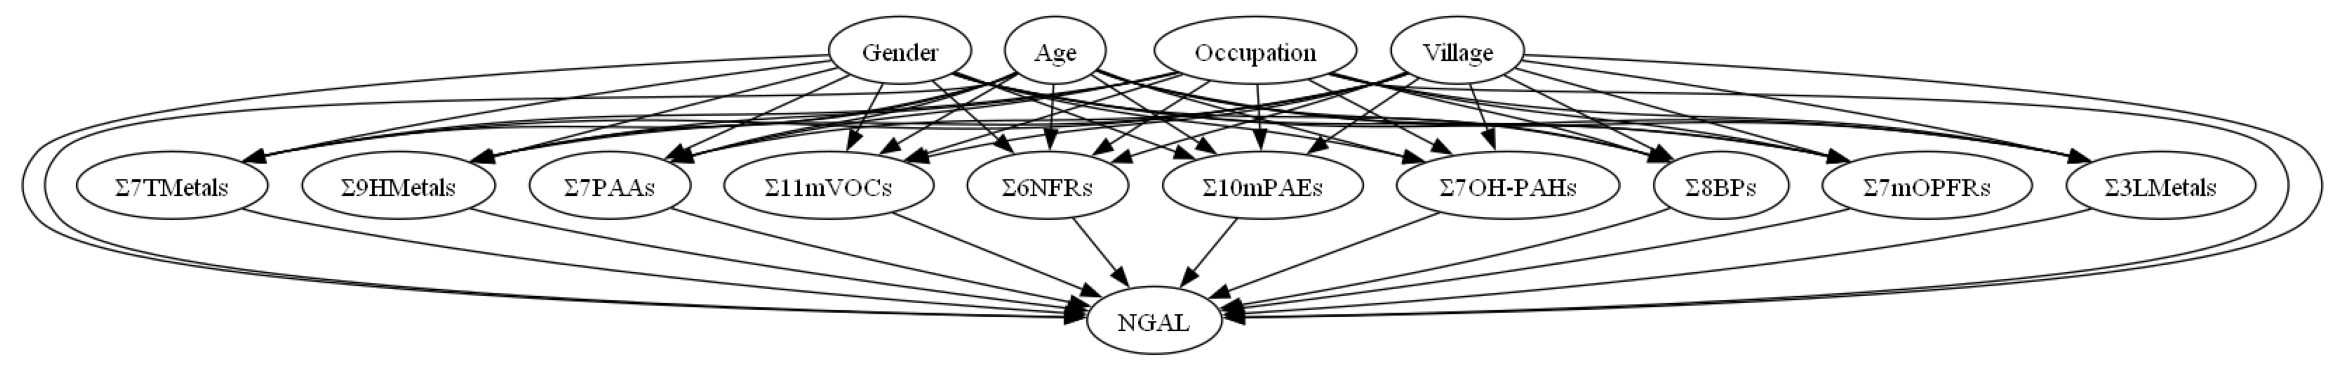

Fitting causal mechanism of node Σ9HMetals: 100%|██████████████████████████████████████| 15/15 [00:01<00:00,  9.25it/s]


In [4]:
causal_graph = nx.DiGraph([

    ('Gender', outcome_var),
    ('Age', outcome_var),
    ('Occupation', outcome_var),
    ('Village', outcome_var), 
    (treatment_var, outcome_var),                         
    ("Σ11mVOCs", outcome_var),
    ("Σ6NFRs", outcome_var),
    ("Σ10mPAEs", outcome_var),
    ("Σ7OH-PAHs", outcome_var),
    ("Σ8BPs", outcome_var),
    ("Σ7mOPFRs", outcome_var),
    ("Σ3LMetals", outcome_var),
    ("Σ7TMetals", outcome_var),
    ("Σ9HMetals", outcome_var),       
    ('Gender', treatment_var),
    ('Age', treatment_var),
    ('Occupation', treatment_var),
    ('Village', treatment_var),                     
    ("Gender","Σ11mVOCs"),
    ("Age","Σ11mVOCs"),
    ("Occupation","Σ11mVOCs"),
    ("Village","Σ11mVOCs"),
    ("Gender","Σ6NFRs"),
    ("Age","Σ6NFRs"),
    ("Occupation","Σ6NFRs"),
    ("Village","Σ6NFRs"),
    ("Gender","Σ10mPAEs"),
    ("Age","Σ10mPAEs"),
    ("Occupation","Σ10mPAEs"),
    ("Village","Σ10mPAEs"),
    ("Gender","Σ7OH-PAHs"),
    ("Age","Σ7OH-PAHs"),
    ("Occupation","Σ7OH-PAHs"),
    ("Village","Σ7OH-PAHs"),
    ("Gender","Σ8BPs"),
    ("Age","Σ8BPs"),
    ("Occupation","Σ8BPs"),
    ("Village","Σ8BPs"),
    ("Gender","Σ7mOPFRs"),
    ("Age","Σ7mOPFRs"),
    ("Occupation","Σ7mOPFRs"),
    ("Village","Σ7mOPFRs"),
    ("Gender","Σ3LMetals"),
    ("Age","Σ3LMetals"),
    ("Occupation","Σ3LMetals"),
    ("Village","Σ3LMetals"),
    ("Gender","Σ7TMetals"),
    ("Age","Σ7TMetals"),
    ("Occupation","Σ7TMetals"),
    ("Village","Σ7TMetals"),
    ("Gender","Σ9HMetals"),
    ("Age","Σ9HMetals"),
    ("Occupation","Σ9HMetals"),
    ("Village","Σ9HMetals") ])

plt.figure(figsize=(30, 30))
gcm.util.plot(causal_graph)

causal_model = gcm.StructuralCausalModel(causal_graph)
causal_model.set_causal_mechanism(treatment_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))
causal_model.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for var in other_var:
    causal_model.set_causal_mechanism(var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for covariate in covariates:
    causal_model.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

gcm.fit(causal_model, data_target)

In [5]:
# Define a range of values for exposure to simulate the dose-response curve
t_values = np.linspace(data_target[treatment_var].min(), data_target[treatment_var].max(), 100)
y_values = []
ci_lowers = []
ci_uppers = []

for t in t_values:
    samples = gcm.interventional_samples(causal_model, {treatment_var: lambda x: t}, num_samples_to_draw=1000)
    y_mean = np.mean(samples[outcome_var])
    y_values.append(y_mean)
    
    # Calculate the 95% confidence interval for the mean
    ci_lower, ci_upper = stats.t.interval(
        0.95, len(samples[outcome_var])-1, loc=y_mean, scale=stats.sem(samples[outcome_var])
    )
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

## STEP.3 Develop a structural causal model (SCM). (with adjustment for smoking status)

In [6]:
treatment_var_ori = 'Σ7PAAs'
treatment_var = 'Σ7PAAs'
other_var = ['Σ11mVOCs',  'Σ6NFRs',   'Σ10mPAEs', 'Σ7OH-PAHs', 'Σ8BPs',  'Σ7mOPFRs' , 'Σ3LMetals',  'Σ7TMetals', 'Σ9HMetals']
outcome_var = 'NGAL'
covariates = ['Gender',  'Age', 'Smoking', 'Occupation', 'Village']

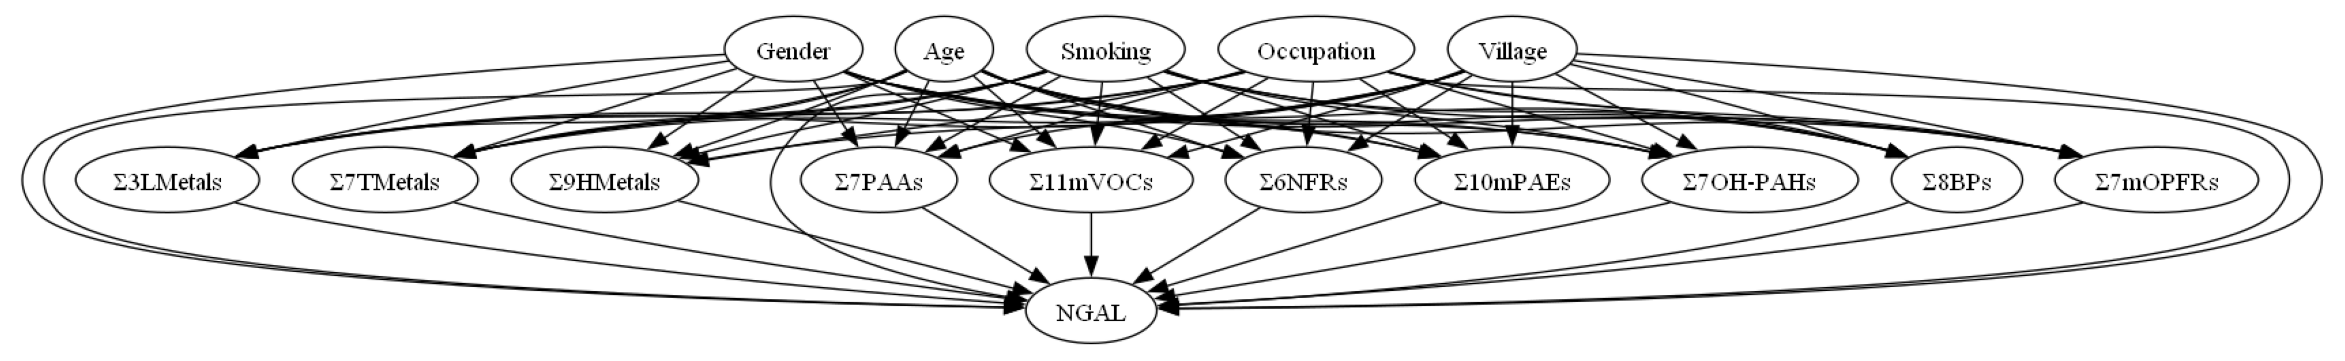

Fitting causal mechanism of node Σ9HMetals: 100%|██████████████████████████████████████| 16/16 [00:01<00:00, 10.06it/s]


In [7]:
causal_graph = nx.DiGraph([

    ('Gender', outcome_var),
    ('Age', outcome_var),
    ('Smoking', outcome_var),
    ('Occupation', outcome_var),
    ('Village', outcome_var), 
    (treatment_var, outcome_var),                         
    ("Σ11mVOCs", outcome_var),
    ("Σ6NFRs", outcome_var),
    ("Σ10mPAEs", outcome_var),
    ("Σ7OH-PAHs", outcome_var),
    ("Σ8BPs", outcome_var),
    ("Σ7mOPFRs", outcome_var),
    ("Σ3LMetals", outcome_var),
    ("Σ7TMetals", outcome_var),
    ("Σ9HMetals", outcome_var),       
    ('Gender', treatment_var),
    ('Age', treatment_var),
    ('Smoking', treatment_var),
    ('Occupation', treatment_var),
    ('Village', treatment_var),                     
    ("Gender","Σ11mVOCs"),
    ("Age","Σ11mVOCs"),
    ("Smoking","Σ11mVOCs"),
    ("Occupation","Σ11mVOCs"),
    ("Village","Σ11mVOCs"),
    ("Gender","Σ6NFRs"),
    ("Age","Σ6NFRs"),
    ("Smoking","Σ6NFRs"),
    ("Occupation","Σ6NFRs"),
    ("Village","Σ6NFRs"),
    ("Gender","Σ10mPAEs"),
    ("Age","Σ10mPAEs"),
    ("Smoking","Σ10mPAEs"),
    ("Occupation","Σ10mPAEs"),
    ("Village","Σ10mPAEs"),
    ("Gender","Σ7OH-PAHs"),
    ("Age","Σ7OH-PAHs"),
    ("Smoking","Σ7OH-PAHs"),
    ("Occupation","Σ7OH-PAHs"),
    ("Village","Σ7OH-PAHs"),
    ("Gender","Σ8BPs"),
    ("Age","Σ8BPs"),
    ("Smoking","Σ8BPs"),
    ("Occupation","Σ8BPs"),
    ("Village","Σ8BPs"),
    ("Gender","Σ7mOPFRs"),
    ("Age","Σ7mOPFRs"),
    ("Smoking","Σ7mOPFRs"),
    ("Occupation","Σ7mOPFRs"),
    ("Village","Σ7mOPFRs"),
    ("Gender","Σ3LMetals"),
    ("Age","Σ3LMetals"),
    ("Smoking","Σ3LMetals"),
    ("Occupation","Σ3LMetals"),
    ("Village","Σ3LMetals"),
    ("Gender","Σ7TMetals"),
    ("Age","Σ7TMetals"),
    ("Smoking","Σ7TMetals"),
    ("Occupation","Σ7TMetals"),
    ("Village","Σ7TMetals"),
    ("Gender","Σ9HMetals"),
    ("Age","Σ9HMetals"),
    ("Smoking","Σ9HMetals"),
    ("Occupation","Σ9HMetals"),
    ("Village","Σ9HMetals") ])

plt.figure(figsize=(30, 30))
gcm.util.plot(causal_graph)

causal_model = gcm.StructuralCausalModel(causal_graph)
causal_model.set_causal_mechanism(treatment_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))
causal_model.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for var in other_var:
    causal_model.set_causal_mechanism(var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for covariate in covariates:
    causal_model.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

gcm.fit(causal_model, data_target_smoking)

In [8]:
# Set fixed seeds for reproducibility
np.random.seed(42)

# Define a range of values for T to simulate the dose-response
t_values_2 = np.linspace(data_target_smoking[treatment_var].min(), data_target_smoking[treatment_var].max(), 100)
y_values_2 = []
ci_lowers_2 = []
ci_uppers_2 = []

for t in t_values_2:
    samples = gcm.interventional_samples(causal_model,
                                     {treatment_var: lambda x: t},
                                     num_samples_to_draw=1000)

    y_mean_2 = np.mean(samples[outcome_var])
    y_values_2.append(y_mean_2)

    
    ci_lower_2, ci_upper_2 = stats.t.interval(
        0.95, len(samples[outcome_var])-1, loc=y_mean_2, scale=stats.sem(samples[outcome_var])
    )
    ci_lowers_2.append(ci_lower_2)
    ci_uppers_2.append(ci_upper_2)

## STEP.4 Comparison of estimates with and without adjustment for smoking status

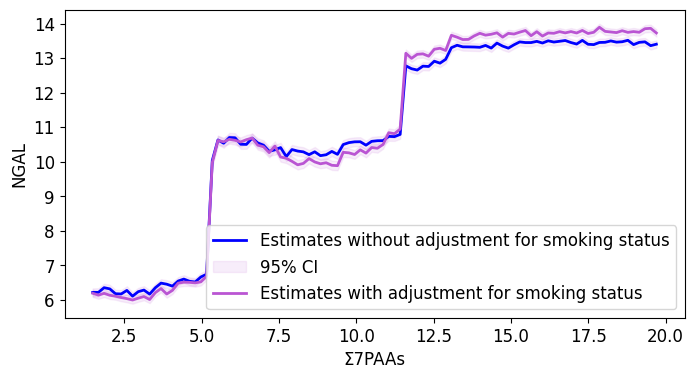

In [9]:
plt.figure(figsize=(8, 4))

plt.plot(t_values, y_values, label='Estimates without adjustment for smoking status', color='blue', linewidth=2)
plt.fill_between(t_values, ci_lowers, ci_uppers, color='mediumorchid', alpha=0.1, label='95% CI')

plt.plot(t_values_2, y_values_2, label='Estimates with adjustment for smoking status', color='mediumorchid', linewidth=2)
plt.fill_between(t_values_2, ci_lowers_2, ci_uppers_2, color='mediumorchid', alpha=0.1)


plt.xlabel(treatment_var_ori,fontsize=12)
plt.ylabel(outcome_var,fontsize=12)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.show()

In [10]:
# Models without adjustment for smoking status
# Calculate the maximum difference of the dependent variable when smoking is not included
effect_1 = max(y_values) - min(y_values)
# Calculate the average confidence interval width when smoking is not included
ci_widths_1 = [u - l for u, l in zip(ci_uppers, ci_lowers)]
avg_ci_width_1 = np.mean(ci_widths_1)

# Models with adjustment for smoking status
# Calculate the maximum difference of the dependent variable when smoking is included
effect_2 = max(y_values_2) - min(y_values_2)
# Calculate the average confidence interval width when smoking is included
ci_widths_2 = [u - l for u, l in zip(ci_uppers_2, ci_lowers_2)]
avg_ci_width_2 = np.mean(ci_widths_2)

# Compare the differences in effect size and accuracy between two models
# Change in effect size (difference or ratio)
effect_difference = effect_2 - effect_1
effect_ratio = effect_2 / effect_1 if effect_1 != 0 else np.nan
# Change in average confidence interval width (difference or ration)
ci_width_difference = avg_ci_width_2 - avg_ci_width_1
ci_width_ratio = avg_ci_width_2 / avg_ci_width_1 if avg_ci_width_1 != 0 else np.nan


print("Difference of change in effect size ΔY: ", effect_difference, ";\nRatio of change in effect size ΔY: ", effect_ratio)
print("\nDifference of change in average confidence interval width: ", ci_width_difference, ";\nRatio of change in average confidence interval width: ", ci_width_ratio)

Difference of change in effect size ΔY:  0.48899600740990845 ;
Ratio of change in effect size ΔY:  1.0660302628137348

Difference of change in average confidence interval width:  -0.010193474050568307 ;
Ratio of change in average confidence interval width:  0.9569974319182294


In [11]:
# Calculate relative changes
effect_unadjusted = effect_1  # Estimates without adjustment for smoking status
effect_adjusted   = effect_2  # Estimates with adjustment for smoking status

if effect_unadjusted != 0:
    relative_change = abs(effect_adjusted - effect_unadjusted) / abs(effect_unadjusted)
else:
    relative_change = np.nan  # If unadjusted effect=0, other explanations or treatments are needed

# Determine if the custom threshold has been exceeded
threshold = 0.10
if relative_change > threshold:
    print(f"After controlling for smoking, the relative change in estimated effect is about {relative_change*100:.2f}%, which is greater than 10%, indicating that smoking has a substantial impact on the estimation.")
else:
    print(f"After controlling for smoking, the relative change in estimated effect is about {relative_change*100:.2f}%, which is less than 10%, indicating that smoking has little impact on the estimation.")


After controlling for smoking, the relative change in estimated effect is about 6.60%, which is less than 10%, indicating that smoking has little impact on the estimation.
